# CEP COVERED BY CURRENTLY ACCREDITED BODYSHOPS

In this notebook:
- We create the table `bodyshops.cep_distance` which features the distances from each CEP to each bodyshop
- We deem which CEP's are currently covered, given that they are at a distance of less than 10km from any of our currently accredited bodyshops


In [1]:
# Imports
import pandas as pd
import numpy as np
import psycopg2, os

# Establish connection and create its cursor
try: 
    conn = psycopg2.connect(f"host={os.environ['AURORA_POSTGRES_HOST']} dbname={os.environ['AURORA_POSTGRES_DATABASE']} user={os.environ['AURORA_POSTGRES_USERNAME']} password={os.environ['AURORA_POSTGRES_PWD']}")
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not make connection to the Postgres database")
    print(e)
    

---

## 1. Tables

We work with `susep.geo_info`, featuring latitude and longitude of every unique CEP code

In [2]:
cur.execute('SELECT * FROM susep.geo_info')
susep_geo_info = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
display(susep_geo_info.head())
display(susep_geo_info.shape)
susep_geo_info.CEP.nunique()


,Id,CEP,code_tract,address_count,lat,lon,reg_susep,cep_inicial,cidade,cep_final,cod_reg,reg_decirc,cep_ini,cep_fim
0,1,76954000,110001520000004,12060,-12.047040,-62.051736,39.0,76740,FAINA,76999,48.0,DEMAIS REGI�ES DE GOI�S,76740,76999
1,777,76873868,110002305000060,11,-9.900819,-63.026831,39.0,76740,FAINA,76999,48.0,DEMAIS REGI�ES DE GOI�S,76740,76999
2,2,76955000,110007205000011,76,-12.983041,-60.952011,39.0,76740,FAINA,76999,48.0,DEMAIS REGI�ES DE GOI�S,76740,76999
3,1553,76965748,110004905000051,8,-11.436342,-61.436585,39.0,76740,FAINA,76999,48.0,DEMAIS REGI�ES DE GOI�S,76740,76999
4,3,76594000,110001505000018,9,-11.928932,-61.990097,39.0,76590,SAO MIGUEL DO ARAGUAIA,76599,48.0,DEMAIS REGI�ES DE GOI�S,76590,76599


(562192, 14)

562192

In [3]:
susep_geo_info.sort_values('code_tract')

,Id,CEP,code_tract,address_count,lat,lon,reg_susep,cep_inicial,cidade,cep_final,cod_reg,reg_decirc,cep_ini,cep_fim
4,3,76594000,110001505000018,9,-11.928932,-61.990097,39.0,76590,SAO MIGUEL DO ARAGUAIA,76599,48.0,DEMAIS REGI�ES DE GOI�S,76590,76599
5,4,79654000,110001505000020,123,-12.029836,-62.016243,37.0,79000,MATO GROSSO DO SUL,79999,46.0,MATO GROSSO DO SUL,79000,79999
8,5,00076954,110001505000024,820,-11.919976,-62.113432,NaN,None,None,None,NaN,None,None,None
9,6,00007694,110001505000031,2,-11.955400,-61.975838,NaN,None,None,None,NaN,None,None,None
0,1,76954000,110001520000004,12060,-12.047040,-62.051736,39.0,76740,FAINA,76999,48.0,DEMAIS REGI�ES DE GOI�S,76740,76999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562174,562175,71692705,530010805300156,25,-15.904766,-47.779890,38.0,70000,BRAS�LIA,72799,47.0,DISTRITO FEDERAL,70000,72799
562173,562174,71692701,530010805300156,27,-15.904766,-47.779890,38.0,70000,BRAS�LIA,72799,47.0,DISTRITO FEDERAL,70000,72799
562190,562191,71692820,530010805300156,35,-15.904766,-47.779890,38.0,70000,BRAS�LIA,72799,47.0,DISTRITO FEDERAL,70000,72799
562181,562182,71692740,530010805300156,31,-15.904766,-47.779890,38.0,70000,BRAS�LIA,72799,47.0,DISTRITO FEDERAL,70000,72799


And also with `bodyshops.accredited`, with the information for each one of our accredited bodyshops, including latitude and longitude

In [3]:
cur.execute('SELECT * FROM bodyshops.accredited')
bodyshops = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
display(bodyshops.head())
display(bodyshops.shape)


,nome_da_oficina,full_address,latitude,longitude,cep,razao_social,cnpj,telefone,responsavel,logradouro,numero,complemento,bairro,cidade,estado,inicio_recebimento,termino_recebimento
0,Scattini Funilaria,"Al,. dos Nhambiquaras 1542 Moema São Paulo SP ...",-23.6112234,-46.6636607,04090-003,Scattini Funilaria e Pintura de Autos Ltda,52.644.093/0001-90,(11) 5543-9622,Junior,"Al,. dos Nhambiquaras",1542,,Moema,São Paulo,SP,8:00:00 AM,6:00:00 PM
1,Oficina Marques (Vila Mascote),Av. Santa Catarina 2580 Vila Mascote São Paulo...,-23.6562648,-46.655485,04378-200,Oficina Marques Funilaria e Pintura Ltda,07.427.476/0001-52,(11) 5535-1903,Cae,Av. Santa Catarina,2580,,Vila Mascote,São Paulo,SP,8:00:00 AM,5:00:00 PM
2,Oficina Marques (Santo Amaro),Av. Santo Amaro 4408 Brooklin São Paulo SP 045...,-23.6216384,-46.6845705,04556-500,Marques e Marques Funilaria e Pintura Ltda,07.427.481/001-65,(11) 5535-1903,Cae,Av. Santo Amaro,4408,,Brooklin,São Paulo,SP,8:00:00 AM,5:45:00 PM
3,Ponce e Filho,R. Butiá 42 Vila Reg. Feijó São Paulo SP 03346...,-23.5588674,-46.5703805,03346-010,Ponce & Filho Ltda,54.824.826/0001-02,(11) 2965-7383,Emilio,R. Butiá,42,,Vila Reg. Feijó,São Paulo,SP,8:00:00 AM,5:30:00 PM
4,Dimas Norte,Av. Gen. Ataliba Leonel 1727 Carandiru São Pau...,-23.4999513,-46.6126825,02033-010,Fiola Reparadora de Veiciulos Eireli,17.237.668/0001-50,(11) 2904-8400,Fiola,Av. Gen. Ataliba Leonel,1727,,Carandiru,São Paulo,SP,8:00:00 AM,5:00:00 PM


(40, 17)

---

## 2. `bodyshops.cep_distance` table

This table features the distance from each bodyshops to each known CEP in meters

In [4]:
# SQL statement (check https://postgis.net/docs/ST_Distance.html for documentation on distance methods)
statement = """CREATE TABLE bodyshops.cep_distance AS (SELECT g."CEP" as cep, 
                                                              g.lon as cep_longitude, 
                                                              g.lat as cep_latitude, 
                                                              b.nome_da_oficina as bodyshop_name, 
                                                              b.longitude as bodyshop_longitude, 
                                                              b.latitude as bodyshop_latitude,
                                                              ST_Distance(ST_Transform(ST_SetSRID(ST_MakePoint(g.lon, g.lat), 4326)::geometry, 3857),
                                                                          ST_Transform(ST_SetSRID(ST_MakePoint(b.longitude, b.latitude), 4326)::geometry, 3857)) as distance_meters
                                                       FROM susep.geo_info AS g 
                                                       CROSS JOIN 
                                                       bodyshops.accredited AS b)"""
# Create the table
cur.execute(statement)
conn.commit()


---
## 3. Analysis of covered bodyshops

In [5]:
# Collect the table for analysis
cur.execute("SELECT * FROM bodyshops.cep_distance")
output = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
display(output.head())

output.shape


,cep,cep_longitude,cep_latitude,bodyshop_name,bodyshop_longitude,bodyshop_latitude,distance_meters
0,76954000,-62.051736,-12.04704,Scattini Funilaria,-46.6636607,-23.6112234,2.184144e+06
1,76954000,-62.051736,-12.04704,Oficina Marques (Vila Mascote),-46.655485,-23.6562648,2.188256e+06
2,76954000,-62.051736,-12.04704,Oficina Marques (Santo Amaro),-46.6845705,-23.6216384,2.183105e+06
3,76954000,-62.051736,-12.04704,Ponce e Filho,-46.5703805,-23.5588674,2.188372e+06
4,76954000,-62.051736,-12.04704,Dimas Norte,-46.6126825,-23.4999513,2.180257e+06


(22487680, 7)

In [6]:
ceps_in_range = output[output['distance_meters']<10000].copy()

Total CEP's in range of any accredited bodyshops

In [7]:
ceps_in_range.cep.nunique()

73496

Distribution of number of bodyshops in range of any given CEP

count    73496.000000
mean         5.468692
std          3.472673
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         16.000000
Name: cep, dtype: float64

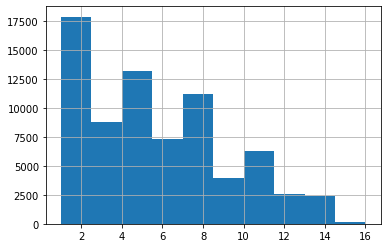

In [8]:
ceps_in_range.cep.value_counts().hist()
ceps_in_range.cep.value_counts().describe()

Some examples, in this case the second to last column (origin is bodyshops by name, destination is cep by coordinates). **This is the projected distance, which doesn't account for the actual path...  I guess this is alright**

In [9]:
ceps_in_range[ceps_in_range.cep==ceps_in_range.cep.value_counts().index[0]]

,cep,cep_longitude,cep_latitude,bodyshop_name,bodyshop_longitude,bodyshop_latitude,distance_meters
13979720,05675010,-46.698241,-23.592493,Scattini Funilaria,-46.6636607,-23.6112234,4471.648930
13979721,05675010,-46.698241,-23.592493,Oficina Marques (Vila Mascote),-46.655485,-23.6562648,9093.453341
13979722,05675010,-46.698241,-23.592493,Oficina Marques (Santo Amaro),-46.6845705,-23.6216384,3853.897959
13979725,05675010,-46.698241,-23.592493,Coronato,-46.6926754,-23.5116367,9838.400687
13979727,05675010,-46.698241,-23.592493,Quatrocentos,-46.7104603,-23.6731984,9900.360344
13979733,05675010,-46.698241,-23.592493,Solução Automotiva,-46.7605456,-23.5993133,6985.003412
13979739,05675010,-46.698241,-23.592493,Funilaria Paulista,-46.6824952,-23.5260509,8257.111499
13979740,05675010,-46.698241,-23.592493,Corifeu Automec,-46.7256709,-23.573455,3830.307623
13979743,05675010,-46.698241,-23.592493,Nicola Garage,-46.6544191,-23.5311412,8905.786270
13979745,05675010,-46.698241,-23.592493,Jotecar,-46.7670739,-23.6393386,9544.900889


![alt text](images/distance1.png "Title")

Let's see examples of CEP we reach with only one bodyshop

In [10]:
ceps_in_range[ceps_in_range.cep.isin(ceps_in_range.cep.value_counts().loc[(ceps_in_range.cep.value_counts()==1)].index)]
                                                                          

,cep,cep_longitude,cep_latitude,bodyshop_name,bodyshop_longitude,bodyshop_latitude,distance_meters
928182,06600000,-46.900948,-23.420386,CB Car,-46.88537,-23.4815434,7620.909744
983635,07272000,-46.402641,-23.358215,Studio Marilia Botelho,-46.3265113,-23.3953212,9595.364105
1000958,06324000,-46.715834,-23.308445,Car Solution Express,-46.7139688,-23.38973,9857.878827
1139715,07400000,-46.351907,-23.345430,Studio Marilia Botelho,-46.3265113,-23.3953212,6678.073079
1759616,06386000,-46.803697,-23.434140,Torque Tamboré,-46.8333405,-23.4926955,7834.781373
...,...,...,...,...,...,...,...
16307504,08692020,-46.320328,-23.492312,Seadriccar,-46.3449644,-23.5004303,2914.129923
16307664,08692025,-46.320328,-23.492312,Seadriccar,-46.3449644,-23.5004303,2914.129923
16307704,08692045,-46.324534,-23.491218,Seadriccar,-46.3449644,-23.5004303,2534.297880
16307784,08692055,-46.324534,-23.491218,Seadriccar,-46.3449644,-23.5004303,2534.297880


---
## 4. Summary table

### 4.1. Target table
We will want a table like this

In [11]:
ceps_in_range = ceps_in_range.sort_values(['cep', 'distance_meters'], ascending=True)
ceps_in_range['proximity_rank_order'] = ceps_in_range.groupby('cep').distance_meters.rank().astype(int)
ceps_in_range.head(10)


,cep,cep_longitude,cep_latitude,bodyshop_name,bodyshop_longitude,bodyshop_latitude,distance_meters,proximity_rank_order
13929212,00000343,-46.496200,-23.708636,Goias Car (Santo Andre),-46.5164876,-23.6617701,6128.312202,1
12763336,00000600,-46.804701,-23.491943,Torque Tamboré,-46.8333405,-23.4926955,3189.477857,1
12763329,00000600,-46.804701,-23.491943,New Fenix,-46.7922508,-23.5190307,3568.399142,2
12763359,00000600,-46.804701,-23.491943,Office Car,-46.8123067,-23.5238926,3969.880671,3
12763334,00000600,-46.804701,-23.491943,Personal Garage,-46.8513418,-23.5082004,5554.468724,4
12763357,00000600,-46.804701,-23.491943,Mec Max,-46.7760856,-23.539489,6592.811902,5
12763342,00000600,-46.804701,-23.491943,CB Car,-46.88537,-23.4815434,9068.340818,6
10164255,00000700,-46.511631,-23.399553,Quadro Rodas Mais,-46.508899,-23.4647337,7913.847052,1
15591177,00000815,-46.415274,-23.520474,Solicar,-46.4509088,-23.5390576,4563.657238,1
15591193,00000815,-46.415274,-23.520474,Donicar,-46.4512972,-23.4975991,4877.738283,2


In [36]:
ceps_in_range.shape

(401927, 8)

### 4.2. SQL process

In [52]:
# SQL statement
statement = """CREATE TABLE bodyshops.summary_table AS (
               SELECT t.cep,
                      t.cep_longitude,
                      t.cep_latitude,
                      t.bodyshop_name,
                      t.bodyshop_longitude,
                      t.bodyshop_latitude,
                      t.distance_meters,
                      ROW_NUMBER() OVER (PARTITION BY t.cep 
                                         ORDER BY t.cep ASC,
                                                  t.distance_meters ASC) AS proximity_rank_order
               FROM bodyshops.cep_distance AS t
               WHERE t.distance_meters<10000
               ORDER BY t.cep ASC,
                       t.distance_meters ASC);"""


# Create the table
#bodyshops.cep_distance
cur.execute(statement)
conn.commit()

Check the table created is the same as the target

In [58]:
# Collect the table for analysis
cur.execute("SELECT * FROM bodyshops.summary_table")
output2 = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

# Compare different values by row, none! :)
ceps_in_range = ceps_in_range.reset_index().drop(columns='index')
(output2!=).sum()


cep                     0
cep_longitude           0
cep_latitude            0
bodyshop_name           0
bodyshop_longitude      0
bodyshop_latitude       0
distance_meters         0
proximity_rank_order    0
dtype: int64

---
## 5. Table for the production process

### 5.1. Target table

In [155]:
# Collect the unique CEP codes we cover
cur.execute("SELECT * FROM bodyshops.summary_table")
output_1 = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
output_1['is_open']=1
output_1 = output_1[['cep', 'is_open']].drop_duplicates().copy()

# Get CEP codes of Grande Sao Paulo
cur.execute("""SELECT "CEP", code_tract FROM susep.geo_info""")
output_2 = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
grande_sao_paulo_ceps = output_2[output_2.code_tract.apply(lambda x: x[:2]=='35')][['CEP']].rename(columns={'CEP':'cep'}).drop_duplicates()



Cross the tables

In [157]:
result = grande_sao_paulo_ceps.merge(output_1, on='cep', how='left')
result

,cep,is_open
0,00009000,NaN
1,07950000,NaN
2,07952000,NaN
3,07990000,NaN
4,06950000,NaN
...,...,...
181552,00018970,NaN
181553,01897000,NaN
181554,18980000,NaN
181555,13857000,NaN


Test the query

In [158]:
statement = """SELECT g.cep, s.is_open FROM
                   (SELECT DISTINCT cep,
                          1 as is_open
                   FROM bodyshops.summary_table) AS s
                   FULL JOIN (
                       SELECT DISTINCT "CEP" as cep
                       FROM susep.geo_info
                       WHERE code_tract LIKE '35%') AS g
                   ON s.cep=g.cep;
               """
cur.execute(statement)
output5 = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
output5


,cep,is_open
0,02319020,1.0
1,04248070,1.0
2,06447445,1.0
3,03342003,1.0
4,02345020,1.0
...,...,...
181552,00187400,NaN
181553,18270805,NaN
181554,08630085,NaN
181555,13272791,NaN


Compare

In [166]:
output5.sort_values('cep').reset_index().drop(columns='index').is_open.sum()

73496.0

Check the snapshot works when refreshing the table of accredited workshops

In [21]:
#cur.execute("SELECT * FROM dbt_albertoscf.covered_ceps_snapshot")
#data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
#data.fillna(0, inplace=True)
#pd.DataFrame(data.groupby('timestamp_changed').is_open.value_counts())

is_open
timestamp_changed         is_open         
2021-12-13 15:26:16+00:00 0.0       108061
                          1.0        73496
2021-12-13 16:00:25+00:00 1.0           14

In [195]:
#cur.execute("DROP TABLE IF EXISTS dbt_albertoscf.cep_codes_all_distances CASCADE")
#cur.execute("DROP TABLE IF EXISTS dbt_albertoscf.cep_codes_summary_table CASCADE")
#cur.execute("DROP TABLE IF EXISTS dbt_albertoscf.covered_ceps CASCADE")
#cur.execute("DROP TABLE IF EXISTS dbt_albertoscf.covered_ceps_snapshot CASCADE")


---
## 6. Sanity checks on snapshot for Mat

Check the data makes sense. 

### 6.1. Get the data
Collect the snapshot

In [6]:
cur.execute("SELECT * FROM dbt_albertoscf.covered_ceps_snapshot")
data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])[['cep', 'is_open', 'timestamp_changed']]
data.fillna(0, inplace=True)
data.head()


,cep,is_open,timestamp_changed
0,00000001,0.0,2021-12-13 15:26:16+00:00
1,00000007,0.0,2021-12-13 15:26:16+00:00
2,00000011,0.0,2021-12-13 15:26:16+00:00
3,00000012,0.0,2021-12-13 15:26:16+00:00
4,00000036,0.0,2021-12-13 15:26:16+00:00


Collect the detail

In [11]:
cur.execute("SELECT * FROM dbt_albertoscf.cep_codes_summary_table")
summary = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
summary.head()


,cep,cep_longitude,cep_latitude,bodyshop_name,bodyshop_longitude,bodyshop_latitude,distance_meters,proximity_rank_order
0,00000200,-46.140157,-23.273968,LSP Reparos,-46.2191402,-23.29531,9164.921096,1
1,00000343,-46.496200,-23.708636,Goias Car (Santo Andre),-46.5164876,-23.6617701,6128.312202,1
2,00000600,-46.804701,-23.491943,Torque Tamboré,-46.8333405,-23.4926955,3189.477857,1
3,00000600,-46.804701,-23.491943,New Fenix,-46.7922508,-23.5190307,3568.399142,2
4,00000600,-46.804701,-23.491943,Office Car,-46.8123067,-23.5238926,3969.880671,3


### 6.2. Some sanity checks
Sample some open cep codes and some closed cep codes

In [33]:
open_cep_sample = list(data[data['is_open']==1].cep.sample(10))
closed_cep_sample = list(data[data['is_open']==0].cep.sample(10))


Query closed in the table

In [34]:
summary[summary['cep'].isin(closed_cep_sample)]

,cep,cep_longitude,cep_latitude,bodyshop_name,bodyshop_longitude,bodyshop_latitude,distance_meters,proximity_rank_order


Collect closed from the distances info

In [35]:
cur.execute("SELECT * FROM dbt_albertoscf.cep_codes_all_distances WHERE cep IN ('"+"', '".join(closed_cep_sample)+"')")
detail = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
detail.head()


,cep,cep_longitude,cep_latitude,bodyshop_name,bodyshop_longitude,bodyshop_latitude,distance_meters
0,12912630,-46.535472,-22.955406,Scattini Funilaria,-46.6636607,-23.6112234,80749.314992
1,12912630,-46.535472,-22.955406,Oficina Marques (Vila Mascote),-46.655485,-23.6562648,85995.550610
2,12912630,-46.535472,-22.955406,Oficina Marques (Santo Amaro),-46.6845705,-23.6216384,82432.042418
3,12912630,-46.535472,-22.955406,Ponce e Filho,-46.5703805,-23.5588674,73222.155203
4,12912630,-46.535472,-22.955406,Dimas Norte,-46.6126825,-23.4999513,66523.290505


Check the pairs at closest distance - which still don't make the 10km cut

In [48]:
detail[detail['distance_meters'].isin(detail.distance_meters.sort_values(ascending=True)[:5])].sort_values('distance_meters')


,cep,cep_longitude,cep_latitude,bodyshop_name,bodyshop_longitude,bodyshop_latitude,distance_meters
346,08742360,-46.225901,-23.541416,Seadriccar,-46.3449644,-23.5004303,14157.339069
357,08742360,-46.225901,-23.541416,Studio Marilia Botelho,-46.3265113,-23.3953212,20970.988203
339,08742360,-46.225901,-23.541416,Solicar,-46.4509088,-23.5390576,25049.397639
355,08742360,-46.225901,-23.541416,Donicar,-46.4512972,-23.4975991,25648.701494
319,12307000,-45.955900,-23.293465,LSP Reparos,-46.2191402,-23.29531,29304.629306


Check them in maps - all of them make sense. Now check open cep codes and check the closest location

In [50]:
summary[(summary['cep'].isin(open_cep_sample)) & (summary['proximity_rank_order']==1)]

,cep,cep_longitude,cep_latitude,bodyshop_name,bodyshop_longitude,bodyshop_latitude,distance_meters,proximity_rank_order
76561,02982180,-46.718787,-23.461054,Coronato,-46.6926754,-23.5116367,6792.789838,1
172025,04283050,-46.604148,-23.607277,Martelinho Bacelar,-46.6472389,-23.606799,4797.195218,1
253090,05324150,-46.754883,-23.545365,Mec Max,-46.7760856,-23.539489,2465.722459,1
338090,06180180,-46.801200,-23.533840,Office Car,-46.8123067,-23.5238926,1728.357035,1
384461,06852460,-46.862017,-23.704212,Centro Automotivo GL,-46.8443961,-23.7056758,1969.612605,1
395768,07273320,-46.415786,-23.459873,Donicar,-46.4512972,-23.4975991,6049.099999,1
401484,08081060,-46.421251,-23.482712,Donicar,-46.4512972,-23.4975991,3801.622904,1
421040,08596650,-46.295647,-23.486892,Seadriccar,-46.3449644,-23.5004303,5730.614482,1
422578,08695410,-46.279610,-23.493968,Seadriccar,-46.3449644,-23.5004303,7317.426795,1
457916,16030250,-46.766367,-23.560397,Mec Max,-46.7760856,-23.539489,2759.801345,1


All good! Export to csv

In [7]:
cur.execute("SELECT * FROM dbt_albertoscf.covered_ceps_snapshot")
data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])[['cep', 'is_open', 'timestamp_changed']]
data.fillna(0, inplace=True)
data['is_open'] = data['is_open'].astype(bool)
data.head()


,cep,is_open,timestamp_changed
0,00000001,False,2021-12-13 15:26:16+00:00
1,00000007,False,2021-12-13 15:26:16+00:00
2,00000011,False,2021-12-13 15:26:16+00:00
3,00000012,False,2021-12-13 15:26:16+00:00
4,00000036,False,2021-12-13 15:26:16+00:00


In [8]:
data.to_csv('open_ceps_v0.csv', index=False)